## Домашнее задание №1

В этом домашнем задании вы познакомитесь с pytorch сами и сможете попрактиковаться в его применении. 

#### План:

1. Простейшие операции в pytorch
2. Пишем Adam и применяем его к ручной модели
3. Обучаем свою первую нейросеть

In [225]:
import os
import sys
import math
import torch
import random
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision.datasets as dsets

### Простейшие операции на pytorch (2 балла)

**Task**: Cоздайте два случайных тензора (двумерных, не квадратных):

In [226]:
x = torch.rand(5, 3)
y = torch.rand(3, 5)

**Task**: Умножьте их друг на друга, результат запишите в третий тензор без использования оператора `=`:

In [227]:
z = torch.Tensor()

In [228]:
torch.matmul(x, y, out=z)

tensor([[0.6760, 0.2038, 0.8908, 0.9816, 0.8915],
        [0.7319, 0.1878, 1.1322, 1.2289, 1.0221],
        [0.1544, 0.0450, 0.1943, 0.2179, 0.2015],
        [0.8075, 0.1263, 0.9381, 1.1697, 1.0648],
        [0.6541, 0.2385, 0.9218, 0.9635, 0.8670]])

**Task**: Реализуйте ReLU использую только pytorch, примените его к тензору `x` (запрещено использование модулей torch.nn и его подмодулей, а также функции torch.relu)

In [229]:
a = torch.tensor((1, 2, -1))
b = torch.tensor((3, 0, 4))
torch.max(a, b)

tensor([3, 2, 4])

In [230]:
def relu_forward(x):
    return torch.max(torch.zeros_like(x), x)

assert torch.all(F.relu(x) == relu_forward(x))

**Task**: Сделайте тоже самое c ELU (запрещено использование модулей torch.nn и его подмодулей):

In [231]:
def elu_forward(z):
    z[z<=0] = torch.exp(z[z <= 0]) - 1
    return z

assert torch.all(F.elu(x) == elu_forward(x))

**Task**: LeakyReLU (запрещено использование модулей torch.nn и его подмодулей):

In [232]:
def lrelu_forward(z, alpha):
    z[z<=0] = z[z<=0] * alpha
    return z

assert torch.all(F.leaky_relu(x, 0.01) == lrelu_forward(x, 0.01))

**Task**: Теперь перейдем к немного более современным функциям активаций, например Mish, напомним как она выглядит:

$$x * tanh(ln(1+e^x))$$

(запрещено использование модулей torch.nn и его подмодулей)

In [233]:
def mish(x):
    return x*torch.tanh(torch.log(1+torch.exp(x)))

In [234]:
assert torch.allclose(
    mish(torch.tensor([1, 1, 1], dtype=torch.float32)), 
    torch.tensor([0.8651, 0.8651, 0.8651]), 
    atol=1e-4
)

assert torch.allclose(
    mish(torch.tensor([0.6376, 0.4021, 0.6656, 0.3726], dtype=torch.float64)), 
    torch.tensor([0.5014, 0.2908, 0.5280, 0.2663], dtype=torch.float64), 
    atol=1e-4
)

**Task**: Теперь реализуем swish, напомним как она выглядит:

$$x * \sigma(x)$$

(запрещено использование модулей torch.nn и его подмодулей)

In [235]:
def swish(x):
    return x*torch.sigmoid(x)

In [236]:
assert torch.allclose(
    swish(torch.tensor([1, 1, 1], dtype=torch.float32)), 
    torch.tensor([0.7311, 0.7311, 0.7311]), 
    atol=1e-4
)

assert torch.allclose(
    swish(torch.tensor([0.6376, 0.4021, 0.6656, 0.3726], dtype=torch.float64)), 
    torch.tensor([0.4171, 0.2409, 0.4396, 0.2206], dtype=torch.float64), 
    atol=1e-4
)

### Пишем Adam и применяем его к линейной регрессии (4 балла)


В данной секции вам нужно сделать две вещи: 

1. Написать свой собственный оптимизатор подобно тому, который мы писали на семинаре
2. Обучить логистическую регрессию побатчево на картинках из датасета 


#### Adam


$$
\begin{eqnarray}
g &=& \frac{1}{m}\nabla_w \sum_i L(f(x_{i};w), y_{i}) \\
m &=& \beta_1 m + (1 - \beta_1) g \\
v &=& \beta_2 v + (1 - \beta_2) diag(gg^{T}) \\
\hat{m} &=& \frac{m}{1 - \beta_1^{t}} \\
\hat{v} &=& \frac{v}{1 - \beta_2^{t}} \\
w &=& w - \frac{\eta}{\sqrt{\hat{v} + \epsilon}} \odot \hat{m}
\end{eqnarray}
$$

In [237]:
# абстрактный класс, не обращайте внимания
from torch.optim import Optimizer


class InClassOptimizer(Optimizer):
    def step(self):
        """Perform single optimization step."""
        with torch.no_grad(): # выключим градиенты
            for group in self.param_groups:
                self._group_step(group)

    def _group_step(self, group):
        # group ~ dict[str, ...]
        """
        Private helper function to perform
        single optimization step on model parameters.
        """
        raise NotImplementedError()

**Task**: Напишите свою реализацию Adam:

In [238]:
class Adam(InClassOptimizer):
    def __init__(self, params, lr=0.001, eps=1e-13, beta_1=0.9, beta_2=0.999):
        defaults = dict(lr=lr, eps=eps, beta_1=beta_1, beta_2=beta_2)
        self.t = 0
        self.m = 0
        self.v = 0
        self.m_ = 0
        self.v_ = 0
        self.params = params
        super().__init__(params, defaults)

    def _group_step(self, group):
        lr = group['lr']
        eps = group['eps']
        beta_1 = group['beta_1']
        beta_2 = group['beta_2']
        for param in filter(lambda x: x.grad is not None, self.params):
            if self.step == 0:
                self.m = torch.zeros_like(d_param)
                self.v = torch.zeros_like(d_param)
            self._init_adam_buffer(param)
            d_param = param.grad
            state = self._get_adam_buffer(param)
            self.t += 1
            self.m = beta_1 * self.m + (1 - beta_1) * d_param
            self.v = beta_2 * self.v + (1 - beta_2) * d_param**2
            self.m_ = self.m / (1 - beta_1 ** self.t)
            self.v_ = self.v / (1 - beta_2 ** self.t)
            param.add_(self.m_/torch.sqrt(self.v_ + eps), alpha=-lr)

    def _get_adam_buffer(self, param):
        param_state = self.state[param]
        return param_state['adam_buffer']

    def _init_adam_buffer(self, param):
        param_state = self.state[param]
        if 'adam_buffer' not in param_state:
            param_state['adam_buffer'] = [torch.zeros_like(param),
                                          torch.zeros_like(param)]

**Task**: Создайте параметры для обучения линейной регрессии, сделаем Xavier ициализацию, которая выглядит следующим образом: 

$$w \sim U[-\frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}, \frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}]$$

где: 

* $n_{in}$ -- размер входа (в нейронах) 28x28
* $n_{out}$ -- размер выхода (в нейронах) 10

Подумайте над выбором $n_{in}$ и $n_{out}$ самостоятельно. 

In [239]:
boarder = 6*.5/(28*28+10)
weights = torch.empty(28*28,10)
torch.nn.init.uniform_(weights, -boarder, boarder)
weights = torch.tensor(weights, requires_grad=True)
intercept  = torch.empty(1,10)
torch.nn.init.uniform_(intercept , -boarder, boarder)
intercept  = torch.tensor(intercept , requires_grad=False)
params = [weights, intercept]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


In [240]:
optimizer = Adam(params)
loss = torch.nn.CrossEntropyLoss()

Загрузим данные и создадим даталоадеры:

In [241]:
train_dataset = torchvision.datasets.FashionMNIST(
    './data',
    download=True,
    transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
)
train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=128,
                                               shuffle=True,
                                               num_workers=1)

test_dataset = torchvision.datasets.FashionMNIST(
    './data',
    train=False,
    download=True,
    transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                               batch_size=128,
                                               num_workers=1)

Напишите функцию для тренировки логистической регрессии, она должна: 
    * Делать предсказания 
    * Считать лосс 
    * Подсчитывать градиенты
    * Делать шаг оптимизации
    * Обнулять посчитанные градиенты
    * Считать метрики 
    * Возвращать полученные метрики
    
После этого предусмотрите возможность визуализировать метрики, чтобы нарисовать картинки, а именно от вас требуется визуализировать: 

    * Зависимость лосса от количества итераций
    * Зависимость доли правильных ответов от количества итераций

In [242]:
def train_logistic_regression(w, b, batch, loss, optimizer):
    images = batch[0].view(-1, 28*28).requires_grad_()
    labels = batch[1]
    optimizer.zero_grad()
    outputs = torch.sigmoid(torch.mm(images, w) + b)
    loss_rate = loss(outputs, labels)
    loss_rate.backward()
    optimizer.step()   

In [243]:
accuracy_list = []
loss_list = []

In [244]:
for epoch in range(100):
    for batch in train_loader:
        bias = intercept
        metrics = train_logistic_regression(weights, bias, batch, loss, optimizer)         
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.view(-1, 28*28).requires_grad_()
        outputs = torch.sigmoid(torch.mm(images, weights) + intercept)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
        loss_rate = loss(outputs, labels)
    
    print('Эпоха: {}, Лосс: {}, Точность: {:.2%}'.format(epoch+1, loss_rate.item(), np.true_divide(correct, total)))
    accuracy_list.append(np.true_divide(correct, total))
    loss_list.append(loss_rate.item())

Эпоха: 1, Лосс: 1.643981695175171, Точность: 73.06%
Эпоха: 2, Лосс: 1.6149747371673584, Точность: 74.85%
Эпоха: 3, Лосс: 1.5915769338607788, Точность: 76.50%
Эпоха: 4, Лосс: 1.577332615852356, Точность: 77.83%
Эпоха: 5, Лосс: 1.5756559371948242, Точность: 78.78%
Эпоха: 6, Лосс: 1.5668364763259888, Точность: 79.58%
Эпоха: 7, Лосс: 1.5510640144348145, Точность: 79.63%
Эпоха: 8, Лосс: 1.5581793785095215, Точность: 80.84%
Эпоха: 9, Лосс: 1.5618046522140503, Точность: 81.18%
Эпоха: 10, Лосс: 1.5438768863677979, Точность: 81.48%
Эпоха: 11, Лосс: 1.547132134437561, Точность: 81.44%
Эпоха: 12, Лосс: 1.546970248222351, Точность: 81.94%
Эпоха: 13, Лосс: 1.5420019626617432, Точность: 81.74%
Эпоха: 14, Лосс: 1.5345420837402344, Точность: 81.85%
Эпоха: 15, Лосс: 1.5382133722305298, Точность: 82.29%
Эпоха: 16, Лосс: 1.5383878946304321, Точность: 82.17%
Эпоха: 17, Лосс: 1.534601092338562, Точность: 82.19%
Эпоха: 18, Лосс: 1.5374339818954468, Точность: 82.50%
Эпоха: 19, Лосс: 1.536522388458252, Точнос

#### Вопросы к секции: 

* Своими словами и без математики объясните благодаря чему Adam дает несмещенную оценку на квадрат градиента
* Когда модель начала переобучаться? Как вы это поняли? Сделайте визуализацию и докажите свою точку зрения.

1. Из-за отсутсвия коэффициентов $\hat{m}$ и $\hat{v}$ в Adagrad и PMSprop не предусмотрена несмещенная оценка на квадрат градиента, можно математически доказать, что E[$g^2$]*(1 - $\beta_2 $)= E[$v_{t}$] с помощью геомерической прогрессии, таким образом $\hat{v}$ сказаывается на начало работы алгоритма и дает несмещенную оценку на квадрат градиента как и $\hat{m}$ 

На графиках видно что после 25 эпохи loss и accuracy начинает увеличиваться тем самым можно сделать вывод, что логистической регрессии для наилучшего обучения понадобилось 25 эпох

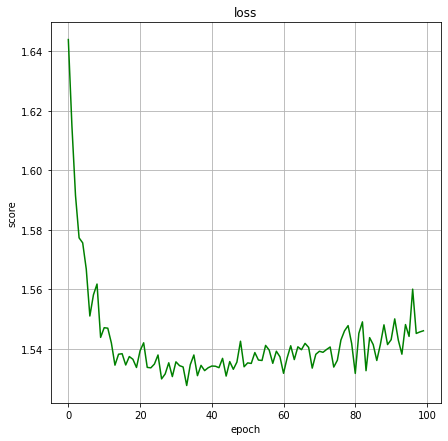

In [245]:
plt.figure(figsize=(7,7))
plt.plot(loss_list, color='g')
plt.title('loss')
plt.xlabel('epoch')
plt.ylabel('score')
plt.grid(True)
plt.show()

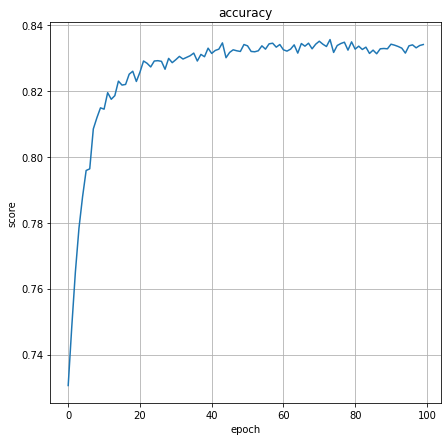

In [246]:
plt.figure(figsize=(7,7))
plt.plot(accuracy_list)
plt.title('accuracy')
plt.xlabel('epoch')
plt.ylabel('score')
plt.grid(True)
plt.show()

### Моя первая нейросеть (4 балла)

В данной секции вам нужно сделать следующие вещи: 

* Реализовать три разных архитектуры нейросетей. Эти архитектуры должны принципиально отличаться друг от друга. Разрешается одной из архитекур брать полностью полносвязную модель. Остальные две должны быть сверточными и сильно отличаться друг от друга. К примеру, одна из таких архитектур может быть VGG подобная сеть, а другая ResNet подобная архитектура. 

* Написать цикл для обучения которым можно обучать все три модели без изменений кода

* Попробовать каждую модель с двумя оптимизаторами: RMSprop и SGD with momentum

* Визуализировать результаты перфоманса каждой модели (две метрики минимум для каждого сетапа, например, лосс и долю правильных ответов). В данном пункте мы ждем от вас визуализацию зависимости метрики от номера итерации обучения.

* Сделать выводы какие были модели были лучше и как вы думаете почему?

In [247]:
def train_model(model, train_loader, test_loader, optimizer):
    epoch = 0
    l = []
    a = []
    print(model[0])
    print(optimizer)
    if model[0] == 'ResNet' and optimizer == 'SGD':
      optim = torch.optim.SGD(model[1]().parameters(), lr=0.01, momentum=0.9)
    elif model[0] == 'ResNet' and optimizer == 'RMSprop':
      optim = torch.optim.RMSprop(model[1]().parameters(), lr=0.001)
    elif optimizer == 'SGD':
        optim = torch.optim.SGD(model[1].parameters(), lr=0.01, momentum=0.9)
    elif optimizer == 'RMSprop':
        optim = torch.optim.RMSprop(model[1].parameters(), lr=0.001)
    model = model[1]
    for epoch in range(5):
        for x_train, y_train in train_loader: 
            x_train = x_train.view(x_train.shape[0], -1)
            y_pred = model(x_train) 
            loss = torch.nn.CrossEntropyLoss()(y_pred, y_train) 
            optim.zero_grad() 
            loss.backward() 
            optim.step() 
            
            loss_list = [] 
            accuracy_list = [] 
        for x_test, y_test in test_loader:
              y_pred = model(x_test) 
              loss_list.append(loss.item()) 
              accuracy_list.extend((torch.argmax(y_pred.data, dim=-1) == y_test.data).numpy().tolist())
        print('Epoch: {}, loss: {}, accuracy: {:.2%}'.format(epoch+1, np.mean(loss_list), np.mean(accuracy_list)))
        
        l.append(np.mean(loss_list))
        a.append(np.mean(accuracy_list))
    return [l, a]

In [248]:
# ResNet
class first_model(nn.Module):
   def __init__(self):
       super(first_model, self).__init__()
       self.fc0 = nn.Conv2d(1, 128, 3, padding=1)
       self.fc1 = nn.Linear(28 * 28, 200)
       self.fc2 = nn.Linear(200, 200)
       self.fc3 = nn.Linear(200, 10)
   def forward(self, x):
        x = self.fc0(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(self.fc1(x))
        return F.log_softmax(x)

In [249]:
# полносвязная модель
second_model = nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(28*28, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 10),
    torch.nn.Softmax(dim=-1)
)

In [250]:
# VGG
third_model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(28*28, 28*28),
    torch.nn.Sequential(nn.ReLU(True), nn.Dropout()),
    torch.nn.Linear(28*28, 28),
    torch.nn.Sequential(nn.ReLU(True), nn.Dropout()),
    torch.nn.Linear(28, 10),
)

In [251]:
# train and visualize and write summary down there
loss_RMS_1, accuracy_RMS_1 = train_model(['Полносвязная модель', second_model], train_loader, test_loader, optimizer ='RMSprop')

Полносвязная модель
RMSprop
Epoch: 1, loss: 1.6911042928695679, accuracy: 77.10%
Epoch: 2, loss: 1.6728154420852661, accuracy: 78.43%
Epoch: 3, loss: 1.7049657106399536, accuracy: 78.85%
Epoch: 4, loss: 1.7402359247207642, accuracy: 79.17%
Epoch: 5, loss: 1.7065258026123047, accuracy: 79.73%


In [252]:
loss_SGD_1, accuracy_SGD_1 = train_model(['Полносвязная модель', second_model], train_loader, test_loader, optimizer ='SGD')

Полносвязная модель
SGD
Epoch: 1, loss: 1.6885385513305664, accuracy: 80.28%
Epoch: 2, loss: 1.6549400091171265, accuracy: 80.30%
Epoch: 3, loss: 1.6316806077957153, accuracy: 80.01%
Epoch: 4, loss: 1.6693129539489746, accuracy: 80.25%
Epoch: 5, loss: 1.626418948173523, accuracy: 80.36%


In [253]:
loss_SGD_2, accuracy_SGD_2 = train_model(['VGG', third_model], train_loader, test_loader, optimizer ='SGD')

VGG
SGD
Epoch: 1, loss: 0.680986225605011, accuracy: 69.61%
Epoch: 2, loss: 0.8638575673103333, accuracy: 74.87%
Epoch: 3, loss: 0.6519922018051147, accuracy: 76.48%
Epoch: 4, loss: 0.6247259974479675, accuracy: 78.05%
Epoch: 5, loss: 0.5637227296829224, accuracy: 79.77%


In [254]:
loss_RMS_2, accuracy_RMS_2 = train_model(['VGG', third_model], train_loader, test_loader, optimizer ='RMSprop')

VGG
RMSprop
Epoch: 1, loss: 0.5835714936256409, accuracy: 76.32%
Epoch: 2, loss: 0.4444028437137604, accuracy: 80.22%
Epoch: 3, loss: 0.5478107929229736, accuracy: 78.94%
Epoch: 4, loss: 0.3344469964504242, accuracy: 81.00%
Epoch: 5, loss: 0.521761953830719, accuracy: 81.05%


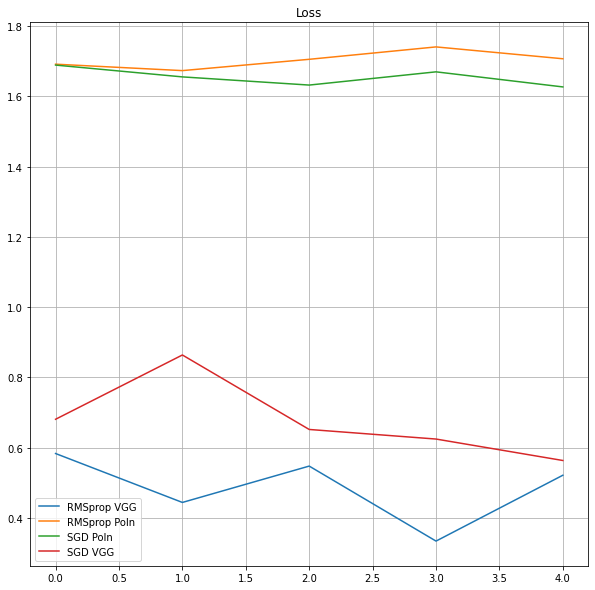

In [255]:
plt.figure(figsize=(10, 10))
plt.plot(loss_RMS_2, label='RMSprop VGG')
plt.plot(loss_RMS_1, label='RMSprop Poln')
plt.plot(loss_SGD_1, label='SGD Poln')
plt.plot(loss_SGD_2, label='SGD VGG')
plt.legend()
plt.title('Loss')
plt.grid(True)
plt.show()

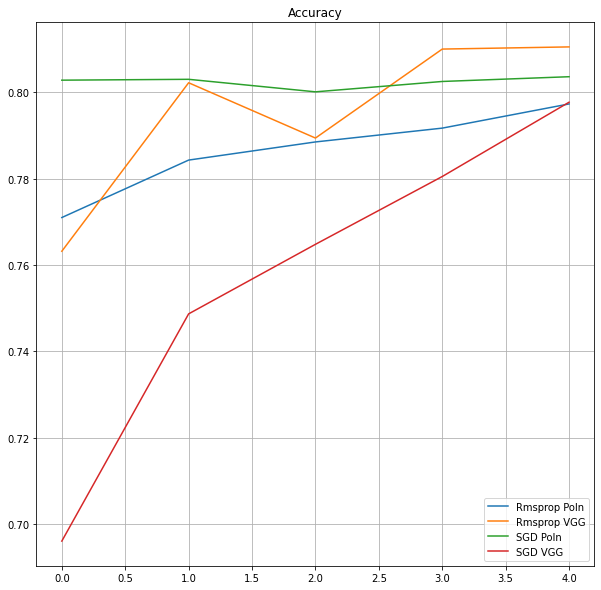

In [256]:
plt.figure(figsize=(10, 10))
plt.plot(accuracy_RMS_1, label='Rmsprop Poln')
plt.plot(accuracy_RMS_2, label='Rmsprop VGG')
plt.plot(accuracy_SGD_1, label='SGD Poln')
plt.plot(accuracy_SGD_2, label='SGD VGG')
plt.legend()
plt.title('Accuracy')
plt.grid(True)
plt.show()

В целом лучше себя показала VGG так как она показала наилучшую точность и мелньшмй лосс в силу дополнительных слоёв и нелмнейных функций внутри себя